# Sentence-BERT를 활용한 두 문장 관계 분류 학습

> 작성자      
```
* 김성현 (bananaband657@gmail.com)  
4기 멘토
이녕우 (leenw2@gmail.com)
박채훈 (qkrcogns2222@gmail.com)
```

[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

이번 실습에서는 [Sentence-BERT](https://arxiv.org/abs/1908.10084) 모델을 통해 두 문장의 관계를 분류해보겠습니다. 

## 01. BERT를 활용한 두 문장 관계 분류 방법

### 방법 1. Sent A와 Sent B의 [CLS] token 임베딩 값을 이용해 유사도 비교
    
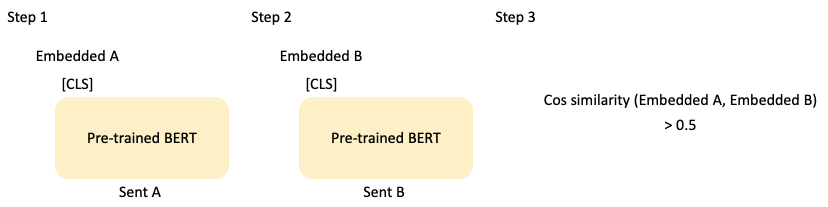


첫 번째 방법은, 이미 학습된 모델을 통해 문장벡터를 획득하여 비교하는 것입니다.   
문장 벡터를 획득하는 방법은 두 가지 방법이 있습니다.   

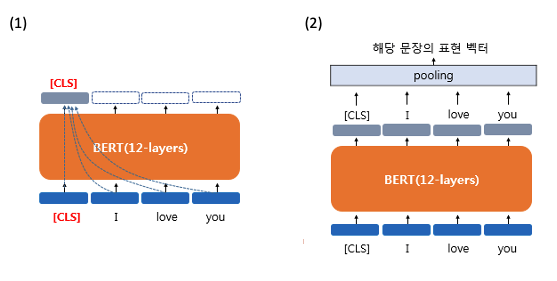

이 경우, 분류의 대상이 되는 모든 문장들을 미리 임베딩해서 저장하고,   
inference 대상이 되는 문장 1개만 임베딩하여 비교함으로써 inference 시간이 절약될 수 있습니다.   
하지만, BERT 모델 자체는 문장 임베딩을 목적으로 학습된 모델이 아니라 성능이 좋지 못할 수 있습니다.

### 방법 2. [SEP] token을 이용해 두 문장 관계 분류 학습    
     
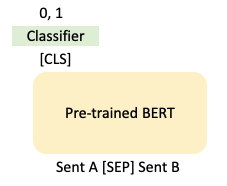

이 경우, 문장의 관계 분류를 위해 학습된 모델로, 좋은 성능이 나타날 수 있습니다.   
하지만, inference 시, 모든 조합들을 새롭게 계산해야하여 시간이 오래걸릴 수 있습니다.    

### 제안 방법. Sentence BERT

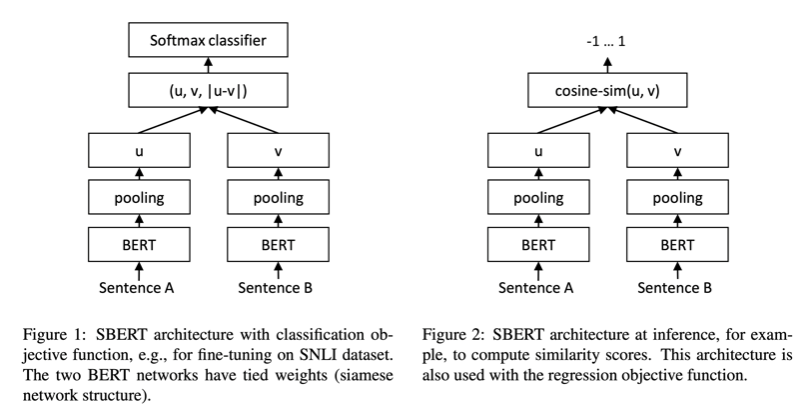

Sentence BERT의 목적은, BERT 모델이 문장의 의미를 잘 '임베딩'하는 것입니다.   
이를 위해, 위 그림과 같이 동일한 BERT 모델이 각각의 Sent A, Sent B를 임베딩하여,   
임베딩 벡터를 이용해 분류 혹은 유사한 정도를 예측하도록 학습합니다.   
결과적으로, BERT 모델이 문장의 의미를 더 정확하게 임베딩할 수 있도록 학습됩니다.   

## 02. Sentence transformer 모델 정의

그럼 본격적으로 sentence BERT 학습을 실습해보겠습니다.  
Sentence BERT를 쉽게 학습, 테스트할 수 있는 라이브러리로 [sentence-transformers](https://www.sbert.net) 를 사용하겠습니다. 

In [1]:
!pip install sentence-transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer, models

In [ ]:
sbert_model_name = "klue/roberta-base"

논문의 그림과 마찬가지로, roberta model의 출력에 pooling layer를 합쳐보겠습니다.

In [ ]:
embedding_model = models.Transformer(sbert_model_name)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

In [ ]:
pooler = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

이제 임베딩 모델과 mean pooling layer를 하나로 합쳐보겠습니다.   
Sentence transformers에서는 아래와 같이 순차적으로 입력해주는 것으로 모델을 구성할 수 있습니다.

In [ ]:
model = SentenceTransformer(modules=[embedding_model, pooler])

In [ ]:
model.to('cuda')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

## 03. 데이터셋 load

두 문장의 관계를 분류하기 위해, klue의 sts 데이터셋을 활용해보겠습니다.

In [ ]:
from datasets import load_dataset

In [ ]:
train_datasets = load_dataset("klue", "sts")['train']
test_datasets = load_dataset("klue", "sts")['validation']

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from sentence_transformers.readers import InputExample

In [ ]:
train_samples = []
test_samples = []

for example in train_datasets:
    score = float(example["labels"]["label"]) / 5.0  # 0.0 ~ 1.0 스케일로 유사도 정규화

    inp_example = InputExample(
        texts=[example["sentence1"], example["sentence2"]], 
        label=score
    )
    train_samples.append(inp_example)

for example in test_datasets:
    score = float(example["labels"]["label"]) / 5.0  # 0.0 ~ 1.0 스케일로 유사도 정규화

    inp_example = InputExample(
        texts=[example["sentence1"], example["sentence2"]], 
        label=score
    )
    test_samples.append(inp_example)


In [ ]:
print(train_samples[0].texts)
print(train_samples[0].label)

['숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.', '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.']
0.74


## 04. Sentence transformers 모델 학습

이제 준비된 데이터셋을 활용해 모델을 학습시켜보겠습니다.   
모델의 학습 방법은 기존의 실습과 동일합니다.   
loss function으로는 cosine similarity를 사용해보겠습니다.   

In [ ]:
from torch.utils.data import DataLoader
from sentence_transformers import losses

In [ ]:
train_dataloader = DataLoader(
    train_samples,
    shuffle=True,
    batch_size=32,
)
train_loss = losses.CosineSimilarityLoss(model=model)

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [ ]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    test_samples,
    name="klue-sts",
)

Sentence transformers는 fit 함수를 통해 학습할 수 있습니다.

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=4,
    evaluation_steps=1000,
    output_path="model_output",
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

학습이 완료되었으니, evaluation 결과를 보겠습니다.

In [ ]:
evaluator(model, output_path='model_output')

0.856689459818131

|epoch|steps|cosine\_pearson|cosine\_spearman|euclidean\_pearson|euclidean\_spearman|manhattan\_pearson|manhattan\_spearman|dot\_pearson|dot\_spearman|
|---|---|---|---|---|---|---|---|---|---|
|-1|-1|0\.8615765138844187|0\.8588697134154512|0\.861459241860082|0\.8553462099940795|0\.8610747970026488|0\.8553471544028912|0\.8498848764036432|0\.8435266332210504|

## 05. Sentence transformers 모델 테스트

In [ ]:
docs = [
    "오늘 환율 어떻게 돼?",
    "오늘 날씨 알려줘",
    "아이유 노래 틀어줘",
]
document_embeddings = model.encode(docs)

In [ ]:
query = "미국 환율 알려줘"
query_embedding = model.encode(query)

In [ ]:
from sentence_transformers import util
import torch

In [ ]:
cos_scores = util.pytorch_cos_sim(query_embedding, document_embeddings)[0]
top_scores, top_idx = torch.topk(cos_scores, k=2)

for i, score in enumerate(top_scores):
    print(i, score.item(), docs[top_idx[i].item()])


0 0.672886848449707 오늘 환율 어떻게 돼?
1 0.1996384561061859 오늘 날씨 알려줘


## Mission

1. 위 코드를 활용해 STS model을 직접 학습해보기
2. 자신의 huggingface 계정에 해당 모델 업로드하기
3. [챗봇 데이터](https://github.com/songys/Chatbot_data)와 자신이 학습한 모델을 사용해 간단한 챗봇 만들어보기

## references

[SNU nlp lab colab example](https://colab.research.google.com/drive/1S6WSjOx9h6Wh_rX1Z2UXwx9i_uHLlOiM#scrollTo=bYRwah9tAitP)   
[Huffon colab example](https://colab.research.google.com/github/Huffon/klue-transformers-tutorial/blob/master/sentence_transformers.ipynb)    
